In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans,MiniBatchKMeans
from tqdm.notebook import tqdm
import joblib

In [1]:
for_kmeans = pd.read_csv('/root/labint/scripts/LabInt/data/GPR1200/images_descriptors_kmeans.csv')
for_quatinzation = pd.read_csv('/root/labint/scripts/LabInt/data/GPR1200/images_descriptors_quant.csv')

In [2]:
#preprocess
for_kmeans = for_kmeans.fillna(0)
for_quatinzation = for_quatinzation.fillna(0)

In [3]:
#for_kmeans

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,image_name,class
0,0.0,1.0,37.0,40.0,16.0,0.0,0.0,1.0,35.0,8.0,...,22.0,56.0,57.0,9.0,0.0,0.0,8.0,34.0,851_131243439820_4.JPG,851_type1
1,4.0,53.0,133.0,36.0,3.0,1.0,0.0,2.0,20.0,98.0,...,6.0,23.0,61.0,23.0,0.0,0.0,1.0,8.0,851_131243439820_4.JPG,851_type1
2,23.0,5.0,1.0,6.0,15.0,28.0,10.0,34.0,32.0,3.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,851_131243439820_4.JPG,851_type1
3,1.0,1.0,3.0,2.0,2.0,4.0,4.0,1.0,17.0,8.0,...,5.0,20.0,28.0,32.0,36.0,3.0,4.0,3.0,851_131243439820_4.JPG,851_type1
4,4.0,2.0,6.0,7.0,0.0,0.0,13.0,38.0,38.0,14.0,...,3.0,0.0,1.0,12.0,82.0,12.0,2.0,5.0,851_131243439820_4.JPG,851_type1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3002356,0.0,131.0,103.0,6.0,2.0,6.0,3.0,0.0,19.0,27.0,...,25.0,34.0,111.0,60.0,12.0,0.0,0.0,0.0,682_079.jpg,682_type1
3002357,5.0,2.0,3.0,26.0,82.0,20.0,22.0,6.0,0.0,0.0,...,12.0,100.0,114.0,6.0,0.0,0.0,2.0,6.0,682_079.jpg,682_type1
3002358,8.0,9.0,31.0,14.0,25.0,8.0,1.0,11.0,87.0,23.0,...,19.0,86.0,54.0,6.0,12.0,27.0,2.0,0.0,682_079.jpg,682_type1
3002359,5.0,35.0,15.0,44.0,21.0,0.0,0.0,1.0,16.0,75.0,...,54.0,17.0,1.0,28.0,94.0,19.0,1.0,4.0,682_079.jpg,682_type1


In [4]:
#def initialize_kmeans(kmeans_df,quatization_df, elbow = True, plot = False):
def initialize_kmeans(kmeans_df, elbow = True, elbow_vector  = np.linspace(10,1000,10, dtype=int) ,plot = False):
    """to calibrate de numer of clusters, use elbow method"""
    kmeans_df = kmeans_df.drop(columns = ['image_name', 'class'])
    #kmeans_df = np.reshape(kmeans_df,(len(kmeans_df)*for_kmeans.iloc[0].shape[0]//128,128))
    #quatization_df = np.reshape(quatization_df,(len(quatization_df)*for_quatinzation.iloc[0].shape[0]//128,128))
    if elbow:
        SSE = []
        numClusters =  elbow_vector

        for k in tqdm(numClusters):
            k_means = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=1)
            k_means.fit(kmeans_df)
            SSE.append(k_means.inertia_)

        plt.plot(numClusters, SSE, marker="o")
        plt.title('Método del codo')
        plt.xlabel('Número de Clusters')
        plt.ylabel('SSE')
        plt.show()

    # choose the best number of clusters based on the variation of the SSE
    variation = [(SSE[i] - SSE[i+1])/ SSE[i] * 100 for i in range(len(SSE)-1)]
    n_clusters = numClusters[variation.index(max(variation)) + 1]
    print(f"El número óptimo de clusters es {n_clusters}")

    #actual kmeans
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, n_init=10, random_state=1)
    kmeans.fit(kmeans_df) #`fit_predict` entrena el modelo y devuelve las predicciones
    if plot:
        y_pred = kmeans.labels_ #kmeans.predict(rates)
        pca = PCA(n_components=2).fit(kmeans_df)
        rates_pca = pca.transform(kmeans_df)
        plt.figure(figsize=(10, 10))
        sns.scatterplot(x=rates_pca[:, 0], y=rates_pca[:, 1], hue=y_pred, palette='Set1',markers='x')
        plt.title(f"Visualización PCA (n = 2) para {n_clusters} clusters por Kmeans")
        plt.show()
    return kmeans, n_clusters

  0%|          | 0/100 [00:00<?, ?it/s]

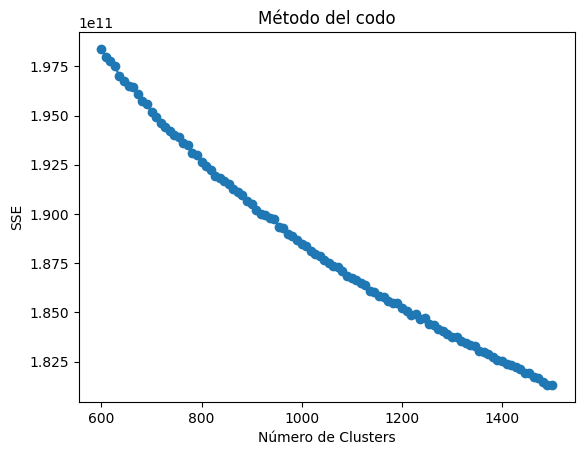

El número óptimo de clusters es 636


In [5]:
model, n_clusters =  initialize_kmeans(for_kmeans, elbow = True, elbow_vector  = np.linspace(100,800,50, dtype=int), plot = False)

In [3]:
#save model
joblib.dump(model, f'kmeans_{n_clusters}.pkl')

NameError: name 'model' is not defined

In [4]:
for_quatinzation = pd.read_csv('/root/labint/scripts/LabInt/data/GPR1200/images_descriptors_quant.csv')



In [5]:
#load model
n_clusters = 636

inferece_model = joblib.load(f'kmeans_{n_clusters}.pkl')
#tag each row with an index corresponding to the number of the descriptor in ascending order

image_name = ""
for row in for_quatinzation.iterrows():
    img_name_aux = row[1]['image_name']
    if img_name_aux != image_name:
        image_name = img_name_aux
        index = 0
    for_quatinzation.loc[row[0], 'index'] = index
    index += 1


NameError: name 'for_quatinzation' is not defined

In [ ]:
image_name = ""
for row in for_quatinzation.iterrows():
    img_name_aux = row[1]['image_name']
    print(img_name_aux)
    break
    if img_name_aux != image_name:
        image_name = img_name_aux
        index = 0
    for_quatinzation.loc[row[0], 'index'] = index
    index += 1

# predict on quantization dataset
for_quatinzation.loc[:,'visual_word'] = inferece_model.predict(for_quatinzation.drop(columns = ['image_name', 'class', 'index']))
# save quantization dataset droping the descriptors
for_quatinzation = for_quatinzation.drop(columns = [f'{i}' for i in range(128)])
for_quatinzation.to_csv('dataset/total_words_quant.csv', index = False)


In [ ]:
#group by image_name and calculate the histogram of visual words
for_quatinzation = pd.read_csv('dataset/total_words_quant.csv')
for_quatinzation = for_quatinzation.drop(columns = ['index', 'class'])
for_quatinzation = for_quatinzation.groupby('image_name').agg(lambda x: x.tolist())
for_quatinzation = for_quatinzation.reset_index()
for_quatinzation['histogram'] = for_quatinzation['visual_word'].apply(lambda x: np.histogram(x, bins = n_clusters, density=True)[0])
for_quatinzation = for_quatinzation.drop(columns = ['visual_word'])
for_quatinzation.to_csv('dataset/total_quant_histogram.csv', index = False)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/total_words_quant.csv'

In [ ]:
# calculate tf-idf of the visual words
#for_quatinzation['idf'] = for_quatinzation['visual_word'].apply(lambda x: np.unique(x, return_counts=True)[1])
#for_quatinzation['idf'] = for_quatinzation['idf'].apply(lambda x: np.log(len(for_quatinzation)/x))
#for_quatinzation['tf'] = for_quatinzation['visual_word'].apply(lambda x: np.unique(x, return_counts=True)[1])
#for_quatinzation['tf'] = for_quatinzation['tf'].apply(lambda x: x/np.sum(x))
#for_quatinzation['tf-idf'] = for_quatinzation['tf'] * for_quatinzation['idf']
#for_quatinzation = for_quatinzation.drop(columns = ['tf', 'idf', 'visual_word'])
#for_quatinzation.to_csv('dataset/total_words_quant_tfidf.csv', index = False)